# Histograms

In [1]:
# HIDDEN
from boot_utes import add_path, path, reload, run_magics

add_path(
    "..",
    "/Users/wbeard/repos/fis/fis/",
    "/Users/wbeard/repos/fis/",
    "~/repos/myutils/",
)
add_path("/Users/wbeard/repos/dscontrib-moz/src/")

11

In [2]:
# HIDDEN
from collections import OrderedDict
from functools import lru_cache, partial, wraps

import altair as A
import pandas as pd
import scipy.stats as sts

import fis.data.load_agg_hists as loh
import fis.utils.fis_utils as fu
import fis.utils.vis as vz
from fis.models import hist as hu
from fis.utils import bq

H = 200
W = 800

In [3]:
# HIDDEN
dfh2_ = bq.bq_query(loh.dl_agg_query())
dfh2 = loh.proc_hist_dl(dfh2_)

/Users/wbeard/miniconda3/envs/fis/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
# HIDDEN
def jlab_kernel():
    import sys

    return any(c.startswith("/Users/wbeard/Library/Jupyter") for c in sys.argv)


if jlab_kernel():
    from matplotlib import MatplotlibDeprecationWarning

    import dscontrib.wbeard as dwb
    from utils.fis_imps import *

    exec(pu.DFCols_str)
    exec(pu.qexpr_str)
    run_magics()
    # import utils.en_utils as eu; import data.load_data as ld; exec(eu.sort_dfs_str)

    mu.set_import_name(mu)
    sns.set_style("whitegrid")
    S = Series
    D = DataFrame

    import dscontrib.wbeard.altair_utils as aau

    aau.set_ds(A)

    DataFrame.pat = aau.pat

Automatic calling is: Smart


In [5]:
# HIDDEN
if jlab_kernel():
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# HIDDEN
if jlab_kernel():
    from numba import typed

    s = dfh2.unq_sites_per_doc
    h = s[0]
    ss = pd.Series(s[0]).sort_index()
    # samps = hu.est_statistic(ss, stat_fn=gmean, quantiles=None)

    mc = "gc_slice_during_idle"

In [4]:
# HIDDEN
TEST = 1


def cache_dict(f):
    @lru_cache()
    def tup_f(tup):
        d = dict(tup)
        return f(d)

    @wraps(f)
    def dict_f(dict_arg):
        tuple_arg = tuple(sorted(dict_arg.items()))
        #         print(tuple_arg)
        return tup_f(tuple_arg)

    return dict_f


gmean = lambda x: sts.gmean(x + 1e-6)

agg_gmean = partial(
    hu.est_statistic,
    n_hists=100 if TEST else 10_000,
    client_draws=10,
    stat_fn=gmean,
    quantiles=[0.05, 0.5, 0.95],
)
agg_gmean_cache = cache_dict(agg_gmean)

In [5]:
# HIDDEN
def summarize_hist_df(df, hist_srs):
    ps = [agg_gmean_cache(h) for h in hist_srs]
    df = pd.concat([df[["date", "br", "n_cid"]], pd.DataFrame(ps)], axis=1)
    return df


# hdf = summarize_hist_df(dfh2, s)

In [25]:
# HIDDEN
hist_dfs = OrderedDict(
    [(hcol, summarize_hist_df(dfh2, dfh2[hcol])) for hcol in loh.hist_cols]
)

## Histograms

In [26]:
# NO CODE
A.data_transformers.enable("default")

plots = [
    vz.plot_errb(hdf).properties(height=H, width=W, title=h)
    for h, hdf in hist_dfs.items()
]

A.vconcat(*plots)

alt.VConcatChart(...)

# Multimodal histograms

In [31]:
# HIDDEN
# fu.s(dfh2['cycle_collector_slice_during_idle'].iloc[0], thresh=.05)

In [32]:
# HIDDEN
mean_mm_cts = pd.concat(
    [
        pd.DataFrame.from_records(dfh2[mc])
        .mean()
        .sort_index()
        .reset_index(drop=0)
        .rename(columns={"index": "k", 0: "count"})
        .assign(h=mc)
        for mc in loh.multimodal_histograms
    ],
    axis=0,
    ignore_index=True,
)

In [30]:
# NO CODE
def _pl(pdf):
    x = "k"
    y = "count"

    h = (
        A.Chart(pdf)
        .mark_point()
        .encode(
            x=A.X(x, title=x),
            y=A.Y(y, title=y, scale=A.Scale(zero=False)),
            tooltip=[x, y,],
        )
    ).properties(height=H, width=W / 2)

    return (h + h.mark_line()).interactive().facet(column="h", columns=3)


_pl(mean_mm_cts)

alt.FacetChart(...)

INFO:tornado.access:304 GET /317439fdfc11a7850236ffa63aa031f9.json (::1) 0.34ms


## cycle_collector_slice_during_idle

In [19]:
# NO CODE
# bins: 0=> ~2%, 100=> ~95%
mm_est1 = hu.mm_hist_quantiles_beta(
    df=dfh2, hcol="cycle_collector_slice_during_idle", bins=[100],
)

vz.stack_bin_plots(mm_est1, h=H, w=W)

alt.VConcatChart(...)

## gc_slice_during_idle

In [20]:
# NO CODE
gcsdi = hu.mm_hist_quantiles_beta(df=dfh2, hcol="gc_slice_during_idle", bins=[0, 100],)

vz.stack_bin_plots(gcsdi, h=H, w=W)

alt.VConcatChart(...)

# Junk
<!-- # HIDDEN -->

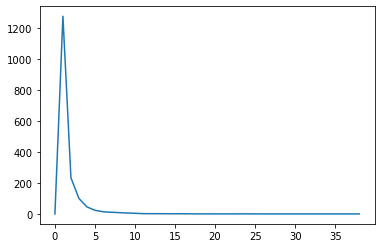

In [21]:
# HIDDEN
pd.Series(dfh2["unq_sites_per_doc"][0]).sort_index().plot()

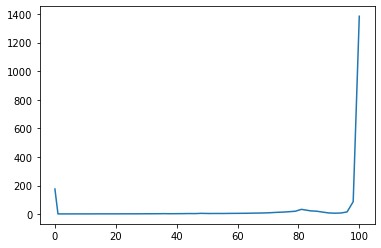

In [22]:
# HIDDEN
pd.Series(dfh2[loh.multimodal_histograms[1]][0]).sort_index().plot()

In [23]:
# HIDDEN
turtle = lambda: defaultdict(turtle)


def fn_tuple(full_fn):
    _loc, fn = os.path.split(full_fn)
    locs = _loc.split("/")[2:]
    return locs, fn


def build_dir_dicts(dirs):
    dirs = [d.split("/")[2:-1] for d in dirs]
    base = fu.AttrDict()
    for bc in base:
        if not bc:
            continue

    print(dirs)


# dirs = glob('../fis/**/', recursive=True)
# build_dir_dicts(dirs)


# fns = sorted([
#     fn_tuple(full_fn) + (full_fn,)
#     for full_fn in glob('../fis/**', recursive=True)
# ], key=lambda x: -len(x[0]))

# fns